In [9]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from math import ceil, floor, log, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from math import log, ceil, floor
from functools import partial

from tqdm import tqdm

# Parameters
# budget = 10**8
alpha = 0.1
# a = 0.8
# b = 1

# a_hat=a
# b_hat=b

def estimate_a_b(p_hat_list):
    m = len(p_hat_list)

    min_p = np.min(p_hat_list)
    max_p = np.max(p_hat_list)
    
    # Bias-corrected estimates of a and b
    a_hat = (m + 1)/m * min_p - (1/m) * max_p
    b_hat = (m + 1)/m * max_p - (1/m) * min_p

    return max([0, a_hat]), min([b_hat, 1])

# Check validity of epsilon
def check_validity_condition(eps, alpha, budget, a_hat=0, b_hat=1, return_val=False):
    b_minus_a = b_hat - a_hat

    if eps > b_minus_a:
        return False
    
    m_star = ceil(abs(log(alpha)) / abs(log(1 - (eps / b_minus_a ) )))
    r_star = budget / m_star
    type_1_error = (1 - (eps - np.sqrt(np.log(r_star) / r_star)) / (b_hat - a_hat))**m_star + 2 * (m_star / np.sqrt(r_star))

    if return_val:
        return type_1_error < alpha, max([0, min([type_1_error, 1])])
    else:
        return type_1_error < alpha

# Check validity of epsilon
# def check_validity_condition_budget_aware(eps, alpha, budget, a_hat=None, b_hat=None, return_val=False):
#     b_minus_a = b_hat - a_hat
    
#     m_star = ceil(abs(log(alpha)) / abs(log(1 - (eps / b_minus_a ) )))
#     min_m_star = 1000
#     r_star = budget / min_m_star
    

#     print(r_star)

#     if a_hat is None and b_hat is None:
#         a_hat, b_hat = estimate_min_ax(m_star, r_star, a, b)
    
    
#     type_1_error = (1 - (eps - np.sqrt(np.log(r_star) / r_star)) / (b_hat - a_hat))**m_star + 2 * (m_star / np.sqrt(r_star))

#     if return_val:
#         return type_1_error < alpha, type_1_error
#     else:
#         return type_1_error < alpha


# Filter epsilon values
# eps_search_list = np.arange(0.005, 0.1, 0.005)
# validity_check_list = [check_validity_condition(eps, alpha, budget, a_hat, b_hat) for eps in eps_search_list]
# valid_epsilon_list = [eps for eps, k in zip(eps_search_list, validity_check_list) if k]
# print(valid_epsilon_list)

    
# Power lower bound estimation
def calculate_approximate_power(a, b, eps, m, r):
    b_minus_a = b - a
    big_q = eps + sqrt(log(r) / r)
    if b_minus_a == 0:
        return -np.inf
    res = (2 / (1 - b_minus_a)) * ((1 - big_q / b_minus_a)**m - 1) * big_q + (1 - 2 * m / sqrt(r))
    return max([0, min([res, 1])])


# Parallel evaluation
def evaluate_epsilon(a_hat, b_hat, eps, alpha, budget, power_type='estimated', n_p_test=1000, n_mc=100, initial_m=100, initial_r=100):
    m = ceil(abs(log(alpha)) / abs(log(1 - eps)))
    r = floor(budget / m)

    if power_type == 'estimated':
        power_list= []
        for i in range(n_mc):
            p_list = np.random.uniform(a, b, initial_m)
            p_hat_list = [np.mean(np.random.binomial(1, p, initial_r)) for p in p_list]
            a_hat, b_hat = estimate_a_b(p_hat_list)
            power_list.append(calculate_approximate_power(a_hat, b_hat, eps, m, r))
        power = np.mean(power_list)
    elif power_type == 'analytical':
        power = calculate_analytical_power(a,b,m,r,epsilon)
    elif power_type == 'simulated':
        power = np.mean(simulate_average_power(a,b,epsilon, m, r,n_p_test, n_mc))
    out = {'m': m, 'r': r, 'approximate_power': power}
    return out


def get_optimal_test(p_hat_list, epsilon_list, alpha, budget):
    argmax_epsilon = -np.inf
    m_star = -np.inf
    r_star = -np.inf
    max_approximate_power=-10e5

    a_hat, b_hat = estimate_a_b(p_hat_list)
    
    for eps in epsilon_list:
        temp = evaluate_epsilon(a_hat,b_hat, eps, alpha, budget)
        if temp['approximate_power'] > max_approximate_power:
            argmax_epsilon=eps
            m_star=temp['m']
            r_star=temp['r']
            max_approximate_power=temp['approximate_power']

    return {'m': m_star, 'r': r_star, 'epsilon': argmax_epsilon, 'approximate_power': max_approximate_power}


def simulate_test(a,b,eps, m, r, p_test):
    p_list = np.concatenate((np.random.uniform(a, b, m), [p_test]))
    p_hat_list = np.array([np.mean(np.random.binomial(1, p, r)) for p in p_list])
    T_mr = min(abs(p_hat_list[:m] - p_hat_list[m]))
    
    return int(T_mr > eps)


def simulate_power_given_p_test(a, b, eps, m, r, p_test, n_mc=1000):
    results = [simulate_test(a, b, eps, m, r, p_test) for _ in range(n_mc)]
    
    return np.mean(results)


def simulate_average_power(a, b, eps, m, r, n_p_test=100, n_mc=10):
    p_test_list = np.random.uniform(0, 1, 20*n_p_test)
    p_test_list = [p for p in p_test_list if (p < a or p > b)]
    p_test_list = p_test_list[:n_p_test]
    
    power_list = Parallel(n_jobs=-1)(delayed(simulate_power_given_p_test)(a, b, eps, m, r, p_test, n_mc) for p_test in p_test_list)
    
    return power_list

def calculate_analytical_power(a,b,m,r,epsilon):
    analytical_power = 2 / ( 1 - (b - a) )
    analytical_power *= ( 1 - ( epsilon + np.sqrt( np.log(r) / r ) ) / (b - a))**m - 1
    analytical_power *= epsilon + np.sqrt(np.log(r) / r)
    analytical_power += 1 - (2*m / np.sqrt(r))

    return max([0, min([analytical_power, 1])])

def estimate_average_power_given_budget(alpha, budget, min_epsilon, max_epsilon, epsilon_step, initial_m=25, initial_r=100, n_p_test=100):
    p_list = np.random.uniform(a, b, initial_m)
    p_hat_list = [np.mean(np.random.binomial(1, p, initial_r)) for p in p_list]
    a_hat, b_hat = estimate_a_b(p_hat_list)

    b_minus_a = b_hat - a_hat

    budget -= initial_m * initial_r
    epsilon_list = np.arange(min_epsilon, max_epsilon + epsilon_step, epsilon_step)
    validity_check_list = [check_validity_condition(eps, alpha, budget, a_hat, b_hat) for eps in epsilon_list]
    valid_epsilon_list = [eps for eps, k in zip(epsilon_list, validity_check_list) if k]

    optimal_test = get_optimal_test(p_hat_list, valid_epsilon_list, alpha, budget)

    return estimate_average_power(a, b, optimal_test['epsilon'], optimal_test['m'], optimal_test['r'], n_p_test)

In [ ]:
np.random.seed(1)

alpha=0.1

budget = 10**7

initial_m=100
initial_r=100

min_epsilon=0.025
max_epsilon=0.1
epsilon_step_size = 0.005
epsilon_list = np.arange(min_epsilon, max_epsilon, epsilon_step_size)

n_mc = 1

budget_list = [10**6, 10**7, 10**8]

size_dict = {}
power_dict = {}

a_b_list = [(0.4, 0.6)]

for (a,b) in a_b_list:
    size_dict[(a,b)] = {}
    power_dict[(a,b)] = {}

    for budget in budget_list:
        size_dict[(a,b)][budget]={}
        power_dict[(a,b)][budget]={}
        
        power_dict[(a,b)][budget]['analytical'] = {}
        power_dict[(a,b)][budget]['estimated'] = {}
        power_dict[(a,b)][budget]['simulated'] = {}
        
        for j,epsilon in enumerate(tqdm(epsilon_list)):
            power_dict[(a,b)][budget]['analytical'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'analytical')['approximate_power']
            power_dict[(a,b)][budget]['estimated'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'estimated', initial_m=initial_m, initial_r=initial_r)['approximate_power']
            power_dict[(a,b)][budget]['simulated'][epsilon] = evaluate_epsilon(a, b, epsilon, alpha, budget, 'simulated', 500, 10)['approximate_power']

 81%|█████████████████████████████████████████████████████████████████               | 13/16 [1:26:52<20:13, 404.62s/it]

[0.9416 0.943  0.9164 0.9038 0.8892 0.8766 0.8514 0.8314 0.8458 0.8172
 0.8486 0.8582 0.7978 0.7712 0.7574 0.7716]
simulated [0.9416 0.943  0.9164 0.9038 0.8892 0.8766 0.8514 0.8314 0.8458 0.8172
 0.8486 0.8582 0.7978 0.7712 0.7574 0.7716]
analytical [0.         0.         0.         0.         0.10292891 0.21820192
 0.28656246 0.33233124 0.37599578 0.41746457 0.43967544 0.46084253
 0.48092931 0.48430941 0.48740162 0.50521955]
estimated [0.         0.         0.         0.         0.06064435 0.17389286
 0.23735714 0.28029439 0.32098297 0.36464202 0.3810997  0.40049205
 0.41666055 0.42046067 0.41985467 0.42871728]
[0.9342 0.9344 0.9136 0.8962 0.9074 0.8954 0.8888 0.8614 0.8662 0.875
 0.833  0.8122 0.8336 0.7934 0.79   0.7534]
simulated [0.9342 0.9344 0.9136 0.8962 0.9074 0.8954 0.8888 0.8614 0.8662 0.875
 0.833  0.8122 0.8336 0.7934 0.79   0.7534]
analytical [0.36278115 0.48230114 0.55903601 0.60708763 0.6374425  0.66547306
 0.67863373 0.68463186 0.68996455 0.6946059  0.69313536 0.69133

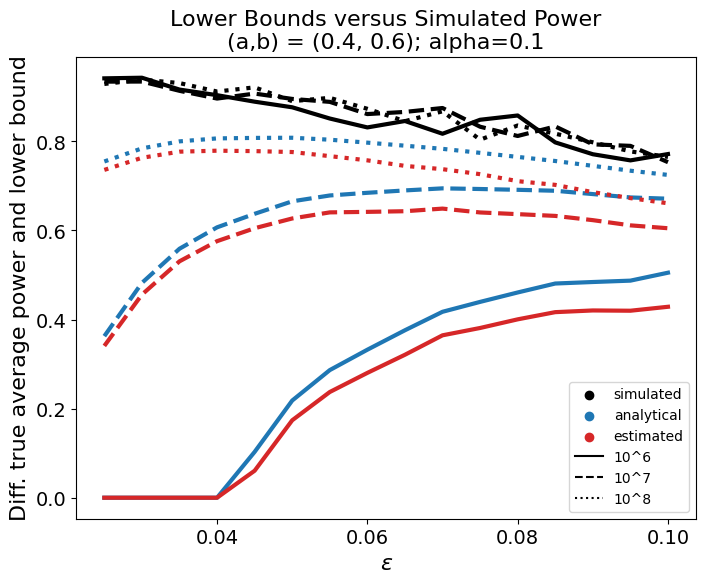

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True)

ls_dict = {10**6: '-', 10**7: '--', 10**8: ':'}
color_dict = {'simulated': 'k', 'analytical': 'tab:blue', 'estimated': 'tab:red'}
for budget in budget_list:
    simulated = np.array(list(power_dict[(a,b)][budget]['simulated'].values())).flatten()
    print(simulated)
    for method in ['simulated', 'analytical', 'estimated']:
        print(method, np.array(list(power_dict[(a,b)][budget][method].values())).flatten())
        values = np.array(list(power_dict[(a,b)][budget][method].values())).flatten()
        # diff = simulated - values
        # print(diff)

        ax.plot(epsilon_list, values, ls=ls_dict[budget], lw=3, c=color_dict[method])

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for method, color in color_dict.items():
    ax.scatter(-100, -100, c=color, label=method)

for budget, ls in ls_dict.items():
    ax.axhline(-100, c='k', label=f'10^{int(np.log10(budget))}', ls=ls)

ax.set_ylim(*ylim), ax.set_xlim(*xlim)
ax.set_title('Lower Bounds versus Simulated Power\n(a,b) = (0.4, 0.6); alpha=0.1', fontsize=16)
ax.set_ylabel('Diff. true average power and lower bound', fontsize=16)
ax.set_xlabel(r'$\epsilon $', fontsize=16)
ax.set_xticks([0.04, 0.06, 0.08, 0.1])
ax.tick_params(labelsize=14)
ax.legend()
# power_dict[(a,b)][10**8][epsilon]